# Interpolacja i transformacje
Opracowanie: A.Florkowska

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from IPython.display import Image

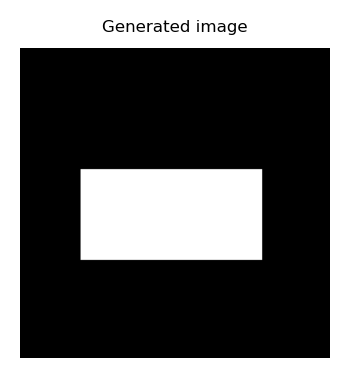

In [6]:
y_size, x_size = 1024, 1024
image = np.zeros((y_size, x_size))
image[400:700, 200:800] = 1
plt.figure(figsize=(2, 4), dpi=200)
plt.imshow(image, cmap='gray')
plt.title("Generated image", fontsize=6)
plt.axis('off')
plt.show()

# Interpolacja
Interpolacja w przetwarzaniu obrazów jest techniką używaną do zmiany rozmiaru obrazów, czyli do powiększania lub pomniejszania, oraz do poprawiania geometrii obrazu w procesach takich jak rotacja czy skos. Umożliwia znalezienie wartości obrazu w niezdefiniowanym punkcie na podstawie sąsiadujących pikseli w taki sposób, aby był on jak najlepiej dopasowany optycznie do transformowanego obrazu ( = płynne przejścia między pikselami i zachowanie jakości obrazu po transformacji). Metoda ta znajduje swoje zastosowanie w wizji komputerowej, edycji obrazów i grafice komputerowej. 

Istnieje kilka głównych metod interpolacji, z których każda oferuje różne kompromisy między jakością a złożonością obliczeniową.

- Interpolacja najbliższego sąsiada
  * To najprostsza i najszybsza metoda interpolacji
  * Polega na przydzieleniu każdemu nowemu pikselowi wartości najbliższego piksela z obrazu źródłowego.
  * Może prowadzić do efektu schodkowania (aliasingu), zwłaszcza przy znaczącym powiększeniu obrazu.
- Interpolacja liniowa (bilinearna)
  * Bardziej zaawansowana metoda
  * Bierze pod uwagę wartości czterech najbliższych pikseli z obrazu źródłowego, aby obliczyć wartość nowego piksela. Dzieje się to poprzez wykonanie liniowej interpolacji najpierw w jednym kierunku, a następnie w drugim - stąd bierze swoją nazwę
  * Uzyskany obraz jest gładszy, w porównaniu z metodą najbliższego sąsiada
- Interpolacja dwusześcienna (bicubic)
  * Jeszcze bardziej zaawansowana technika
  * W obliczeniach uwzględnia 16 najbliższych pikseli (4x4 otoczenie piksela docelowego).
  * Używa wielomianów trzeciego stopnia do wygładzania przejść między pikselami, co prowadzi do jeszcze większej płynności obrazu. Jest to często używana metoda w profesjonalnych aplikacjach do edycji obrazów ze względu na dobrą równowagę między jakością a czasem przetwarzania.
 
Wybór metody interpolacji jest często podyktowany różnymi warunkami: czasem przetwarzania, oczekiwaną jakością obrazu wyjściowego czy typem danych wejściowych. Przykładowo, podczas analizy obrazów binarnych (wartości 0 lub 1) nie można użyć interpolacji liniowej (wprowadziłaby nową uśrednioną wartość, inną niż 0 lub 1), zalecana jest wtedy metoda najbliższego sąsiada.

# Interpolacja metodą najbliższego sąsiada 2D - algorytm

1. Zaokrąglenie wspołrzędnych do najbliższych mniejszych liczb całkwoitych, aby znaleźć najbliższe punkty w macierzy.
2. Sprawdzenie, czy wyznaczone indeksy nie wychodzą poza granice macierzy danych.
3. Obliczenie współczynników wagowych.
4. Interpolacja na podstawie obliczonych współczynników i wartości pikseli najbliższych punktów danych.

[0.28733089 0.28613359 4.85646777 1.14341793 0.39154883 4.97060371
 5.88098333 0.27290376 0.68184608 4.97293591]
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0 0.0 0.0
0.0
0 1 0 1
0 1 0 1
0.0 0.0

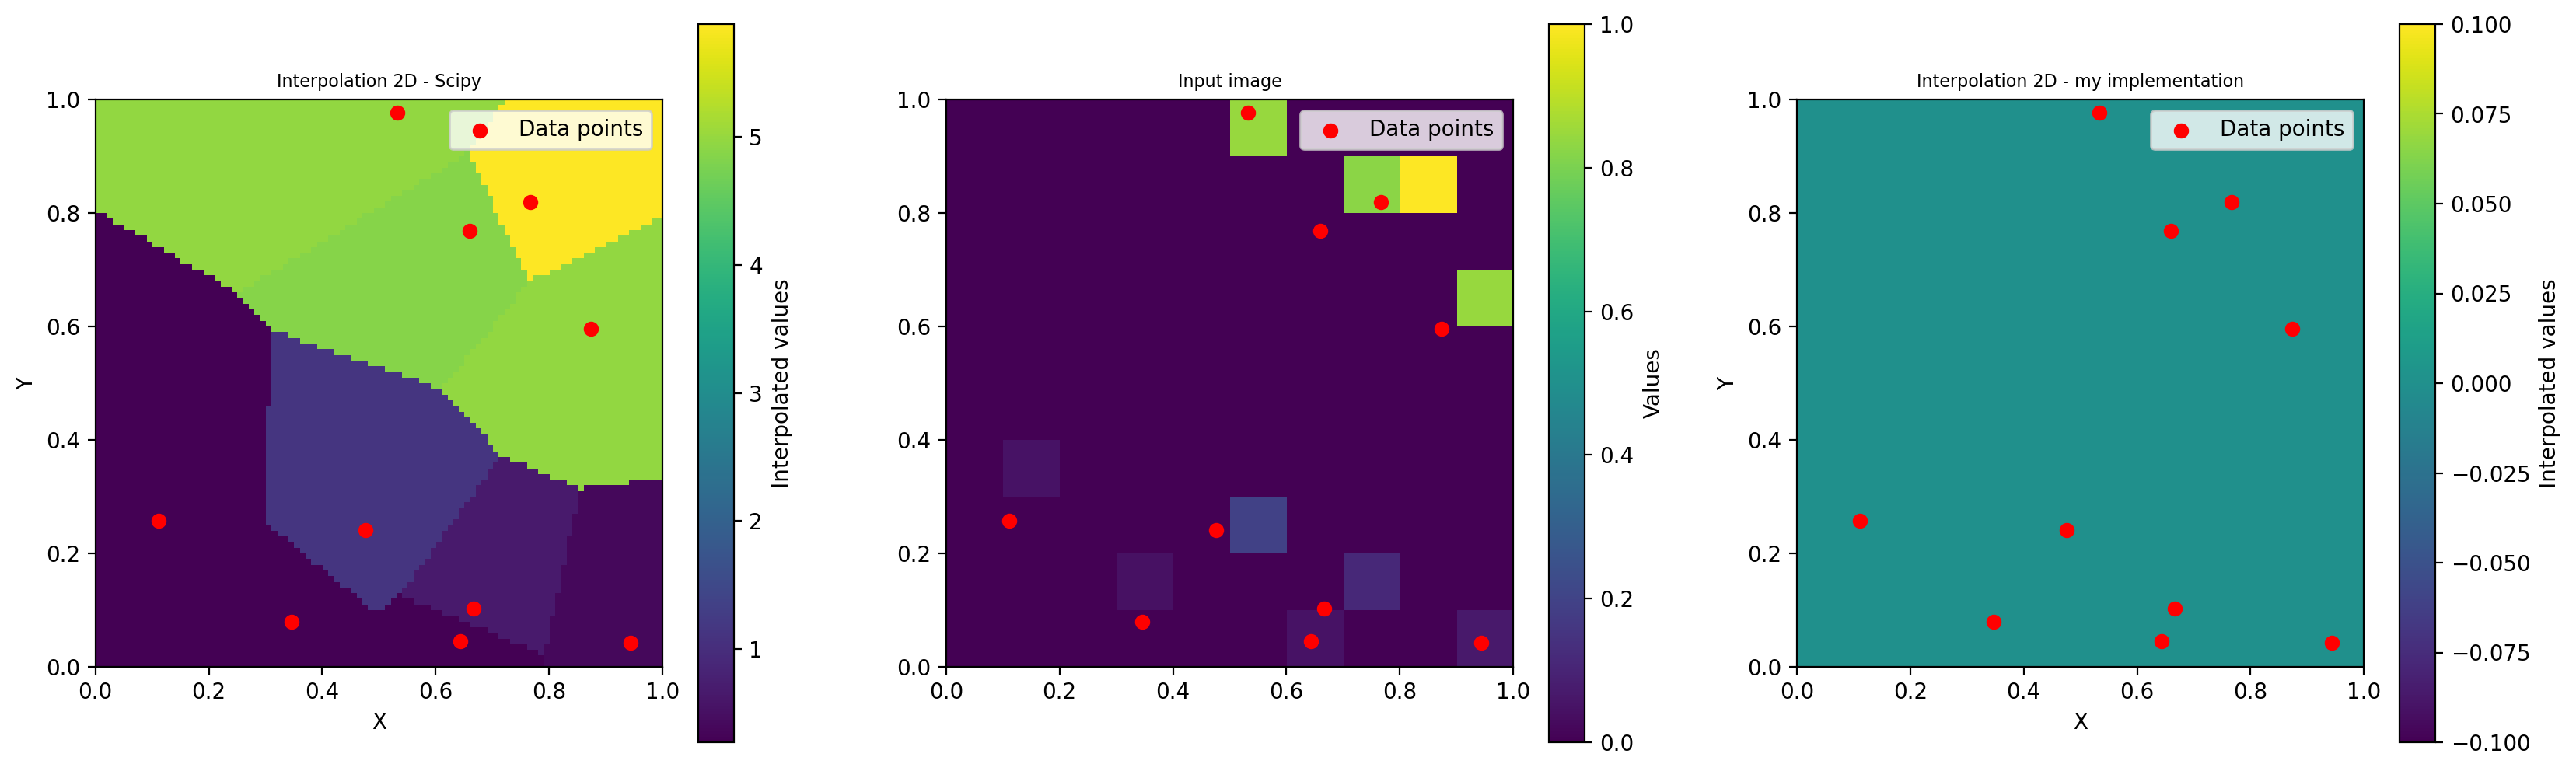

In [57]:
def interpolate_2d(image, grid_x, grid_y):
    # Assuming image is a 2D array and grid_x, grid_y are 2D meshgrids
    new_img = np.zeros_like(grid_x)
    
    for index_y, i in np.ndenumerate(grid_y):
        j = grid_x[index_y]
        y_up, y_down = np.int64(np.floor(i)), np.int64(np.floor(i) + 1)
        x_left, x_right = np.int64(np.floor(j)), np.int64(np.floor(j) + 1)
        print( y_up, y_down, x_left, x_right)
        # Clipping indices to ensure they fall within the image bounds
        y_up, y_down = np.clip([y_up, y_down], 0, image.shape[0]-1)
        x_left, x_right = np.clip([x_left, x_right], 0, image.shape[1]-1)
        print( y_up, y_down, x_left, x_right)
        # Extracting values for interpolation
        a = image[y_up, x_left]
        b = image[y_up, x_right]
        c = image[y_down, x_left]
        d = image[y_down, x_right]
        print(a,b,c,d)
        # Calculating weights
        w_x = j - x_left
        w_y = i - y_up

        # Weighted sum
        interpolated_point = a*(1 - w_x) * (1 - w_y) + b*w_x * (1 - w_y) + c*(1 - w_x) * w_y + d*w_x * w_y
        
        # Assigning the interpolated value to new_img
        print(interpolated_point)
        new_img[index_y] = interpolated_point

    return new_img
    
# def interpolate_2d(image, grid_x, grid_y):
#   new_img = np.zeros_like(grid_x)
 
#   for i in grid_y[0]:
#     for j in grid_x[0]:
#       y_up, y_down = np.int64(np.floor(i)), np.int64(np.floor(i)+ 1)
#       x_left, x_right = np.int64(np.floor(j)), np.int64(np.floor(j) + 1)

#       a = image[y_up, x_left]
#       b = image[y_up, x_right]
#       c = image[y_down, x_left]
#       d = image[y_down, x_right]

#       w_x = j - x_left
#       w_y = i - y_up

#       wA = (1 - w_x) * (1 - w_y)
#       wB =  w_x * (1 - w_y)
#       wC = w_y * (1 - w_x)
#       wD = w_x * w_y

#       interpolated_point = a*wA + b*wB + c*wC + d*wD 
#       new_img[x_left][y_up] = interpolated_point
#   return new_img

N = 10
x = np.random.rand(N)
y = np.random.rand(N)
values = np.sin(x * y) * 10
print(values)
matrix = np.zeros((N, N))
index = 0
for i,j in zip(y,x):
    x_int = np.clip(int(np.round(i*10)), 0, x.shape[0] - 1)
    y_int = np.clip(int(np.round(j*10)), 0, y.shape[0] - 1)
    matrix[x_int][y_int] = values[index]
    index+=1
    
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# Data interpolation from points (x, y) to a grid (x_grid, y_grid)
values_interp = griddata((x, y), values, (x_grid, y_grid), method='nearest')
values_my_interp = interpolate_2d(matrix, x_grid, y_grid)

plt.figure(figsize=(20, 6), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(values_interp, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated values')
plt.scatter(x, y, c='r', label='Data points')
plt.legend(loc='best')
plt.title('Interpolation 2D - Scipy', fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.subplot(1, 3, 2)
plt.imshow(matrix, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.scatter(x, y, c='r', label='Data points')
plt.legend(loc='best')
plt.colorbar(label='Values')
plt.title('Input image', fontsize=8)
plt.subplot(1, 3, 3)
plt.imshow(values_my_interp, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated values')
plt.scatter(x, y, c='r', label='Data points')
plt.legend(loc='best')
plt.title('Interpolation 2D - my implementation', fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Transformacja 
To działanie mające na celu manipulację obiektami lub obrazami poprzez zmianę ich położenia, rozmiaru, kształtu lub orientacji w przestrzeni. Obejmuje poniższe działania:
* Translacja: Przesuwanie obiektu lub obrazu w określonym kierunku.
* Skalowanie: Zmiana rozmiaru obiektu lub obrazu poprzez zmianę jego wymiarów.
* Obrót: Obracanie obiektu lub obrazu wokół określonego punktu lub osi.
* Przekształcenie afiniczne: Złożona transformacja obejmująca translację, skalowanie, obrót i/lub ścinanie.
* Ścinanie: Zniekształcanie obiektu lub obrazu poprzez zastosowanie przekształcenia perspektywicznego.

Wyróżnia się również dwa rodzaje transformacji: 
- Transformacja sztywna (rigid transformation)
  * Zachowuje odległości i kąty między punktami w przestrzeni.
  * Oznacza to, że obiekt poddany transformacji sztywnej zostaje przesunięty, obrócony lub obrotno-przesunięty (czyli przesunięty i obrócony jednocześnie), ale jego kształt i rozmiar nie ulegają zmianie.
  * Transformacja sztywna jest definiowana przez translację (przesunięcie) i/lub obrót obiektu. 
- Transformacja afiniczna (affine transformation)
  * Zachowuje linie prostą, ale niekoniecznie odległości i kąty.
  * Oznacza to, że obiekt poddany transformacji afinicznej może zostać przesunięty, obrócony, skalowany i ścinany (przekształcony perspektywicznie).
  * W przeciwieństwie do transformacji sztywnej, transformacja afiniczna może również zmieniać kształt i rozmiar obiektu. 

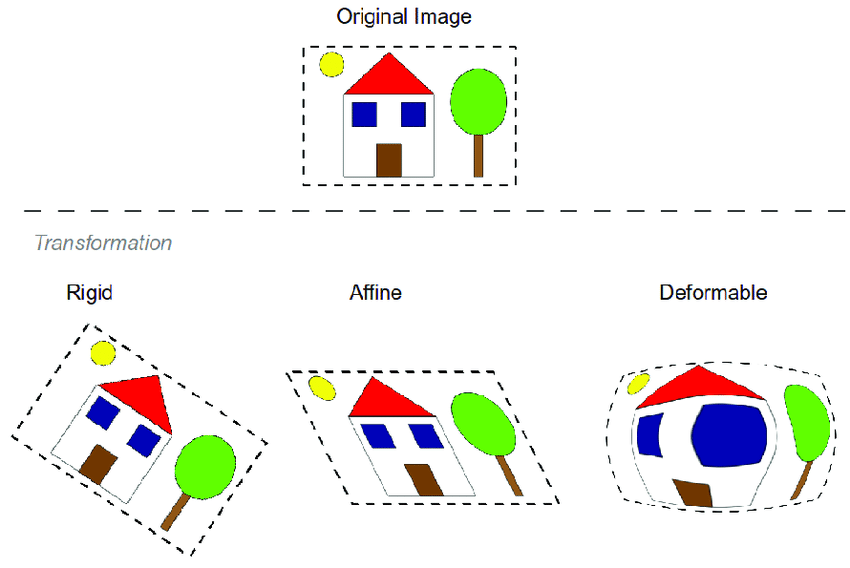

In [10]:
Image(filename=".././images/8_1.png", width=600)
# Source: https://www.researchgate.net/figure/Three-types-of-transformations-visualized-in-2D-rigid-affine-and-deformable-Rigid_fig8_279825250 

# Macierze transformacji
Transformacje są wykonywane za pomocą macierzy transformacji, które opisują zmianę współrzędnych obiektów w przestrzeni. Każda operacja transformacji ma swoją macierz odpowiadającą za to przekształcenie. Na przykład, macierz translacji przesuwa obiekt o określony wektor, macierz skalowania zmienia rozmiar obiektu przez mnożenie współrzędnych przez odpowiednie skale, a macierz obrotu obraca obiekt o określony kąt.

Macierze mają wymiar o jeden większy niż przestrzeń na której operują, czyli przekształcenie w 2D to macierz 3x3, a w 3D to 4x4.

In [4]:
# todo: dodac zdjecie ze wzorami na wszystkie macierze 

In [7]:
def generate_rigid_matrix(xtranslation, ytranslation, rot_angle):
  rot = np.deg2rad(rot_angle)
  rigid_matrix = np.array([
      [np.cos(rot), -np.sin(rot), xtranslation],
      [np.sin(rot), np.cos(rot), ytranslation],
      [0, 0, 1]                     
      ])
  return rigid_matrix

# Example of rigid matrix enabling translation about 100px along x-axis and -40px along y-axis, as well as rotation about 45 degree.
rigid_matrix=generate_rigid_matrix(100,-40,45)
print(rigid_matrix)

[[  0.70710678  -0.70710678 100.        ]
 [  0.70710678   0.70710678 -40.        ]
 [  0.           0.           1.        ]]


In [ ]:
# todo: obrót względem srodka, wlasna implementacja transformacji sztywnej

# Pole przemieszczeń obrazu
Pole przemieszczeń obrazu opisuje przesunięcia punktów obrazu względem ich położenia referencyjnego. Jest to wektorowe pole, które określa, o ile każdy piksel obrazu został przesunięty w kierunku poziomym i pionowym. Jest to szczególnie użyteczne w rejestracji obrazów, gdzie celem jest dopasowanie dwóch obrazów poprzez znalezienie transformacji, która minimalizuje różnice między nimi.
# Pole deformacji
Pole deformacji obrazu opisuje zmiany kształtu i rozmiaru obrazu względem jego pierwotnej formy. Jest to tensorowe pole, które może opisywać zarówno liniowe (przesunięcia, skalowania) jak i nieliniowe (skręty, rozciągnięcia) deformacje. Pole deformacji może być wykorzystywane do modelowania zmian obrazu w wyniku różnych czynników, takich jak zmiany perspektywy, deformacje strukturalne itd.

Techniki polegające na wyznaczaniu pól przemieszczeń i deformacji obrazu są wykorzystywane w wielu dziedzinach przetwarzania obrazów, takich jak medycyna, grafika komputerowa, analiza obrazów, itp. Mogą być stosowane do zastosowań takich jak rejestracja obrazów medycznych, śledzenie ruchu obiektów na obrazach wideo, korekcja obrazów w przypadku zniekształceń geometrycznych, generowanie efektów graficznych itd. 